In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import itertools as it
from collections import Counter, defaultdict, deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from mouselab_utils import *
from joblib import load

In [3]:
from glob import glob
import re
from utils import Labeler
labeler = Labeler()

def load_rollouts():
    for f in glob('data/rollouts/constant_high_1/*.pkl'):
        d = load(f)
        d['phi'] = list(d['phi'])
        df = pd.DataFrame(d)
        seed = re.search('(\d+)\.pkl', f).group(1)
        df['env_seed'] = seed
        df['trial_id'] = seed + '-' + df.trial_id.astype(str)
        df['state'] = df.s
        df.s = df.s.apply(labeler)
        yield df

data = pd.concat(load_rollouts())

In [65]:
df = data.set_index(['s', 'a'], drop=True)

In [10]:
data.groupby(['state', 'a']).q.mean().to_pickle('data/monte_carlo_q.pkl')

In [4]:
g = data.groupby(['s', 'a'])
counts = g.apply(len)
Xt = np.stack(g.phi.apply(lambda x: x.iloc[0]))
yt = g.q.mean().as_matrix()

In [71]:
qmean = g.q.mean()
df['q_mean'] = qmean[df.index]

In [72]:
phi = np.stack(df.phi)

In [73]:
df['yhat'] = model.predict(phi)

KeyboardInterrupt: 

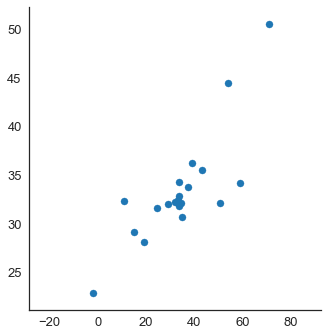

In [90]:
sns.lmplot('q_mean', 'yhat', data=df, n_boot=500, x_bins=20)

In [97]:
from sklearn.linear_model import LinearRegression
y = df.q_mean.as_matrix()

model = LinearRegression().fit(X, y)
print(model.intercept_, model.coef_.round(3))
yhat = model.predict(X)
abs_err = abs(y - yhat)
print(f'r^2 = {model.score(X, y):.2f}')
print(f'abs_err / std(y) = {abs_err.mean() / y.std():.2f}')

-0.679915869407 [ 1.038 -0.036  0.313  0.783 -0.021 -0.17  -0.13   0.   ]
r^2 = 0.30
abs_err / std(y) = 0.56


In [49]:
err = abs(g.q.mean() - yhat)
qdf = pd.DataFrame({'counts': counts, 'err': err, 'q': g.q.mean()})


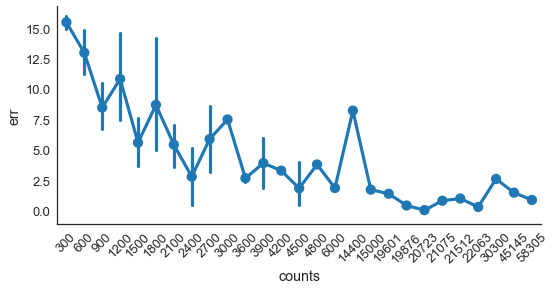

In [50]:
g = sns.factorplot('counts', 'err', data=qdf, aspect=2)
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

In [92]:
abs(df.q_mean - df.yhat).mean()

10.8742580809648

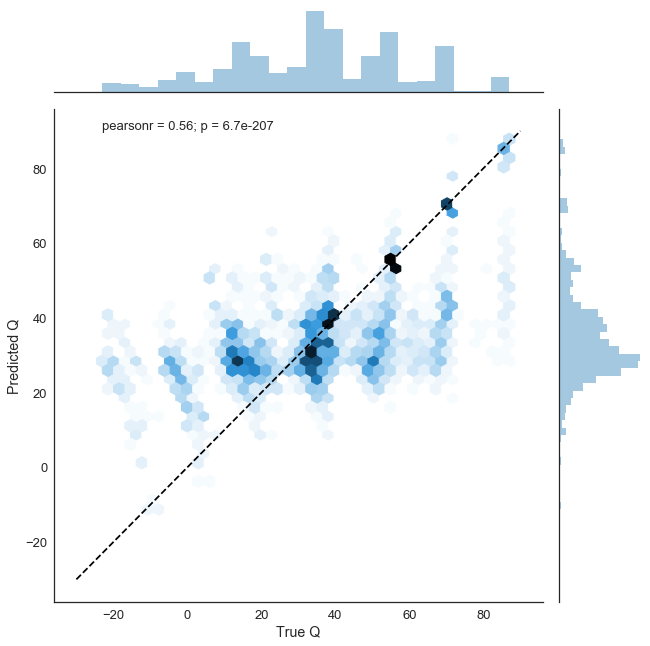

In [54]:
g = sns.jointplot(yt, yhat, kind='hex', size=9)
g.ax_joint.set_ylabel('Predicted Q')
g.ax_joint.set_xlabel('True Q')
g.ax_joint.plot([-30, 90], [-30, 90], c='k', ls='--')